In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
from collections import defaultdict
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import GridSearchCV

2024-12-16 21:05:25.031230: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the Titanic dataset
data = pd.read_csv("../Titanic-Dataset.csv")

# Features and target variable
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
target = "Survived"
X = data[features]
y = data[target]

# 1. Impute Missing Values
# For numerical features: fill missing values with the mean
X["Age"] = X["Age"].fillna(X["Age"].mean())
X["Fare"] = X["Fare"].fillna(X["Fare"].mean())

# For categorical features: fill missing values with the mode
X["Embarked"] = X["Embarked"].fillna(X["Embarked"].mode()[0])

# 2. Scale Numerical Features (Manually in Pandas)
numeric_features = ["Age", "SibSp", "Parch", "Fare"]
X[numeric_features] = X[numeric_features].apply(lambda col: (col - col.mean()) / col.std())

# 3. Encode Categorical Features
X['Sex'] = X['Sex'].map({'male': 0, 'female': 1})
X['Embarked'] = X['Embarked'].astype('category').cat.codes

# Adjusted feature_columns to include new one-hot-encoded columns
print("Final feature columns:", list(X.columns))

# Train-Test Split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Example: Print the transformed dataset
print(X_train.head())


Final feature columns: ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
     Pclass  Sex       Age     SibSp     Parch      Fare  Embarked
517       3    0  0.000000 -0.474279 -0.473408 -0.162078         1
792       3    1  0.000000  6.780355  2.007806  0.751524         2
472       2    1  0.253875  0.432550  2.007806 -0.089634         2
483       3    1  2.561209 -0.474279 -0.473408 -0.455125         2
9         2    1 -1.207437  0.432550 -0.473408 -0.042931         0


/var/folders/xt/n8jr18d50g77dmf3dbmvsxv00000gn/T/ipykernel_1728/338793199.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Age"] = X["Age"].fillna(X["Age"].mean())
/var/folders/xt/n8jr18d50g77dmf3dbmvsxv00000gn/T/ipykernel_1728/338793199.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Fare"] = X["Fare"].fillna(X["Fare"].mean())
/var/folders/xt/n8jr18d50g77dmf3dbmvsxv00000gn/T/ipykernel_1728/338793199.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [4]:
# Build the MLP model
def create_mlp(learning_rate=0.001, activation='relu', num_layers=2, units_per_layer=32, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(units_per_layer, activation=activation, input_dim=X_train.shape[1]))
    for _ in range(num_layers - 1):
        model.add(Dense(units_per_layer, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Binary output
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'binary_accuracy'])
    return model

In [5]:
# Wrap the model for GridSearchCV
model = KerasClassifier(model=create_mlp, verbose=0)

# Hyperparameter grid
param_grid = {
    'model__learning_rate': [0.001, 0.01],
    'model__activation': ['relu', 'softmax', 'sigmoid'],
    'model__num_layers': [1, 2],
    'model__units_per_layer': [16, 32],
    'model__dropout_rate': [0.2, 0.4],
    'batch_size': [8, 16, 32],
    'epochs': [10]
}

# GridSearchCV setup
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, refit=True)

# Fit the model
grid_result = grid.fit(X_train, y_train)

/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Fitting 3 folds for each of 144 candidates, totalling 432 fits


/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

In [21]:
# print(pd.DataFrame(grid_result.cv_results_)['params'])

print(pd.DataFrame(grid.cv_results_)[['param_batch_size', 'param_epochs', 'param_model__activation', 'param_model__dropout_rate', 'param_model__learning_rate', 'param_model__num_layers', 'param_model__units_per_layer']])

     param_batch_size  param_epochs param_model__activation  \
0                   8            10                    relu   
1                   8            10                    relu   
2                   8            10                    relu   
3                   8            10                    relu   
4                   8            10                    relu   
..                ...           ...                     ...   
139                32            10                 sigmoid   
140                32            10                 sigmoid   
141                32            10                 sigmoid   
142                32            10                 sigmoid   
143                32            10                 sigmoid   

     param_model__dropout_rate  param_model__learning_rate  \
0                          0.2                       0.001   
1                          0.2                       0.001   
2                          0.2                       0.00

In [6]:
# Best parameters and results
print("Best parameters:", grid_result.best_params_)
print("Best score:", grid_result.best_score_)

print("Best Estimator:", grid_result.best_estimator_)

# Evaluate the best model on the test set
test_accuracy = grid_result.best_estimator_.score(X_test, y_test)
# test_loss = grid_result.best_estimator_.loss(, y_test)
print(f"Test Accuracy: {test_accuracy}")

Best parameters: {'batch_size': 32, 'epochs': 10, 'model__activation': 'relu', 'model__dropout_rate': 0.4, 'model__learning_rate': 0.01, 'model__num_layers': 1, 'model__units_per_layer': 32}
Best score: 0.8225099786503295
Best Estimator: KerasClassifier(
	model=<function create_mlp at 0x161dc1260>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	class_weight=None
	model__activation=relu
	model__dropout_rate=0.4
	model__learning_rate=0.01
	model__num_layers=1
	model__units_per_layer=32
)
Test Accuracy: 0.8100558659217877


/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


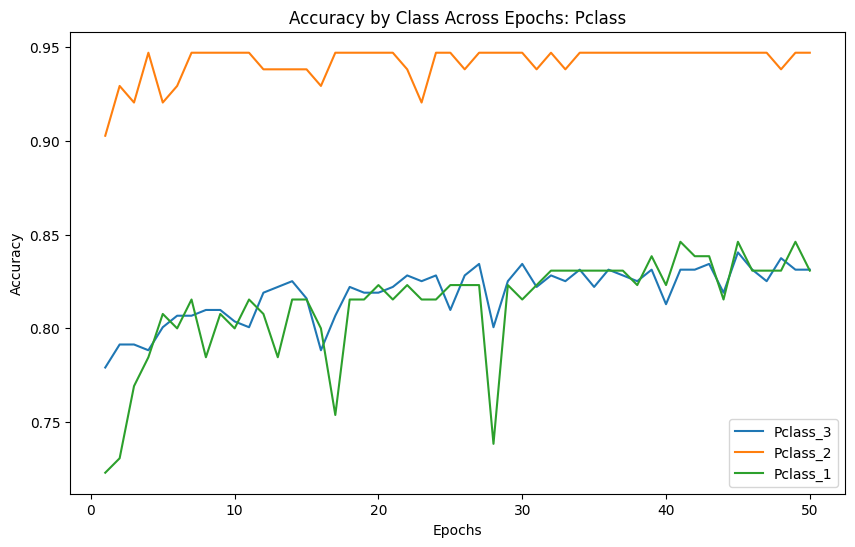

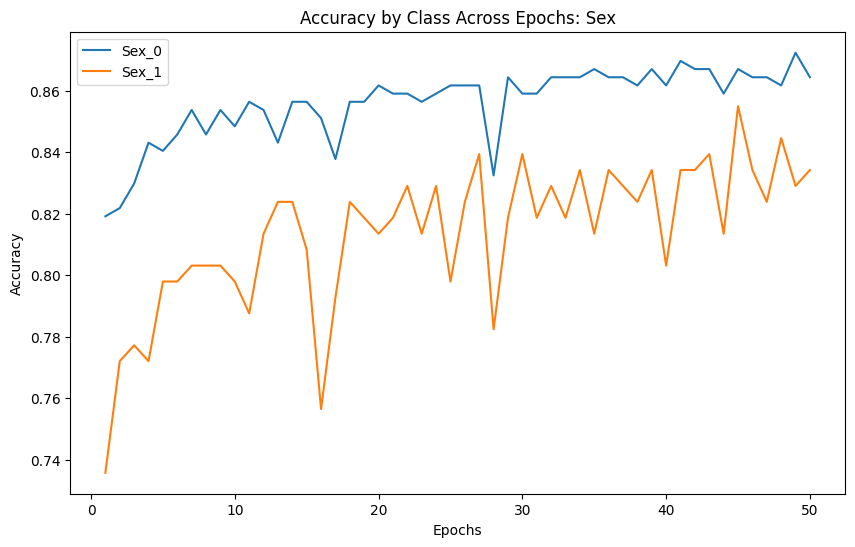

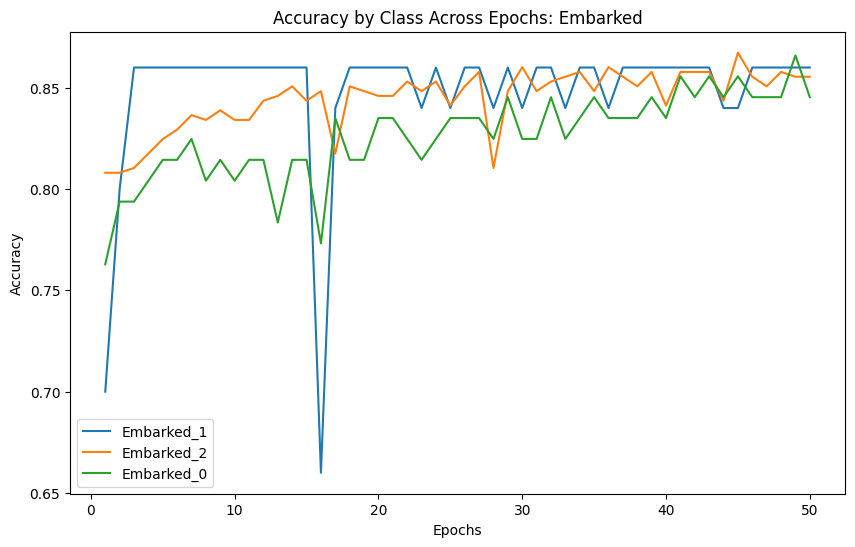

In [7]:
# Extract best parameters
best_params = grid_result.best_params_

# Extract individual parameters
best_learning_rate = best_params['model__learning_rate']
best_activation = best_params['model__activation']
best_num_layers = best_params['model__num_layers']
best_units_per_layer = best_params['model__units_per_layer']
best_dropout_rate = best_params['model__dropout_rate']
best_batch_size = best_params['batch_size']

# Create a new model with the best parameters
model = create_mlp(
    learning_rate=best_learning_rate,
    activation=best_activation,
    num_layers=best_num_layers,
    units_per_layer=best_units_per_layer,
    dropout_rate=best_dropout_rate
)

# Prepare to track accuracy across feature classes
history = {'epoch': [], 'accuracy_by_class': []}

# Define the categorical features explicitly
categorical_features = [
    col for col in X_train.columns if col.startswith(('Sex', 'Embarked'))  # Example prefixes
]

# Dict to store accuracies for each category across epochs
accuracy_by_class = {feature: defaultdict(list) for feature in categorical_features}

# Add EarlyStopping to avoid overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',   # Watch validation loss
    patience=5,           # Stop if no improvement for 5 consecutive epochs
    restore_best_weights=True  # Restore the best model weights
)

# Training loop with validation data
for epoch in range(50):
    history = model.fit(
        X_train, y_train,
        epochs=1, 
        batch_size=32,
        verbose=0,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )

    # Get predictions on training data
    predictions = (model.predict(X_train) > 0.5).astype(int).flatten()

    # Compute accuracy for each category in each feature
    for feature in categorical_features:
        for category in X_train[feature].unique():
            # Filter rows where the feature matches the current category
            category_mask = X_train[feature] == category

            # Ground truth and predictions for this category
            y_true_category = y_train[category_mask]
            y_pred_category = predictions[category_mask]

            # Accuracy: Correct predictions / Total predictions for this category
            if len(y_true_category) > 0:
                accuracy = (y_true_category == y_pred_category).mean()
                accuracy_by_class[feature][category].append(accuracy)

# Plots for each feature
for feature, categories in accuracy_by_class.items():
    plt.figure(figsize=(10, 6))
    for category, accuracies in categories.items():
        plt.plot(range(1, len(accuracies) + 1), accuracies, label=f"{feature}_{category}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy by Class Across Epochs: {feature}")
    plt.legend()
    plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


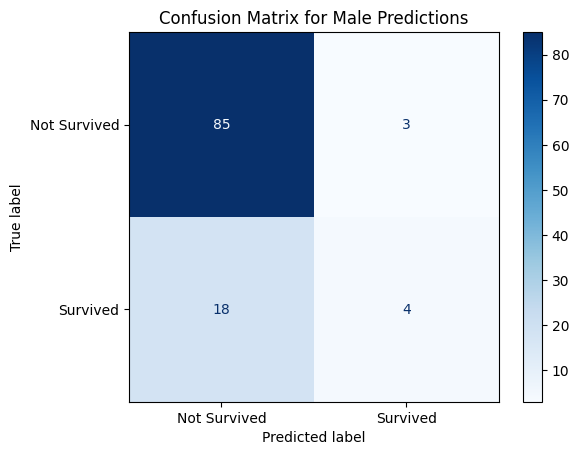

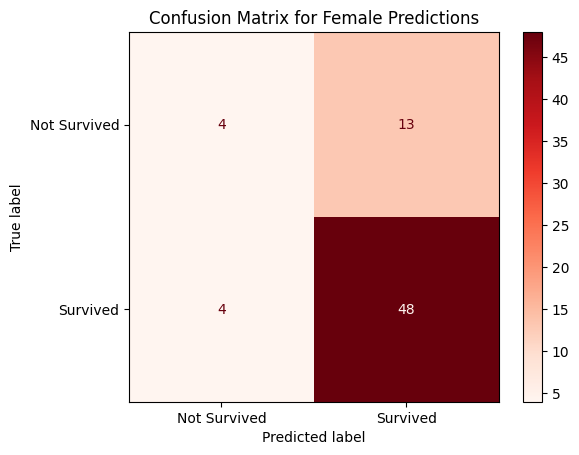

In [37]:
# Generate predictions on the test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Confusion matrix for gender-based predictions
gender_column = 'Sex'  # Adjust based on your column naming
male_indices = X_test[gender_column] == 0
female_indices = X_test[gender_column] == 1

# Confusion matrix for males
cm_male = confusion_matrix(y_test[male_indices], y_pred[male_indices])
disp_male = ConfusionMatrixDisplay(confusion_matrix=cm_male, display_labels=['Not Survived', 'Survived'])
disp_male.plot(cmap='Blues')
plt.title("Confusion Matrix for Male Predictions")
plt.show()

# Confusion matrix for females
cm_female = confusion_matrix(y_test[female_indices], y_pred[female_indices])
disp_female = ConfusionMatrixDisplay(confusion_matrix=cm_female, display_labels=['Not Survived', 'Survived'])
disp_female.plot(cmap='Reds')
plt.title("Confusion Matrix for Female Predictions")
plt.show()


In [41]:
# print(pd.DataFrame(grid_result.cv_results_)['params'])

print(pd.DataFrame(grid.cv_results_)[['param_batch_size', 'param_epochs', 'param_model__activation', 'param_model__dropout_rate', 'param_model__learning_rate', 'param_model__num_layers', 'param_model__units_per_layer']].to_csv('../gridsearch_results.csv'))

None
